# Practical Project: Analyzing and Evaluating Cancerous Tissue Size Using MRI

This project focuses on segmenting, measuring, and comparing cancerous tissue in MRI images to monitor disease progression or treatment effectiveness.


## Project Workflow & Implementation

### 1️⃣ Data Acquisition

MRI Dataset:

Use publicly available MRI datasets such as: BraTS (Brain Tumor Segmentation Dataset) – https://www.kaggle.com/code/bilalakgz/brain-tumor-segmentation-u-net3d/input

### Imaging Data Description
All BraTS multimodal scans are available as NIfTI files (.nii.gz):

* native (T1)
* post-contrast T1-weighted (T1Gd)
* T2-weighted (T2)
* T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes

and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1).

## 2️⃣Preprocessing
Load MRI images to grayscale using NIBABEL – Handling MRI data in NIfTI/DICOM format

Normalize intensity values to enhance contrast.

Apply noise reduction using Gaussian Blur or Non-Local Means Denoising (cv2.fastNlMeansDenoising()).

Histogram equalization to improve visibility of tissues.

(240, 240, 155)


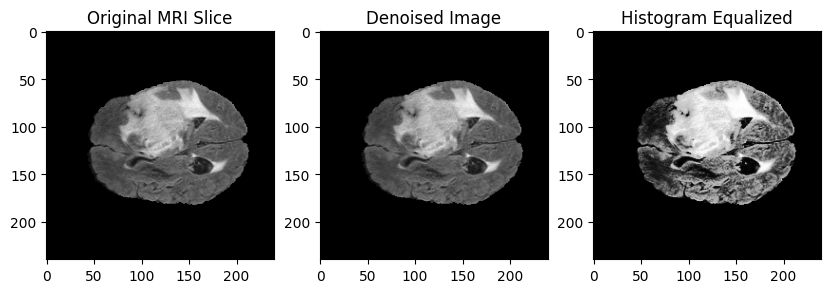

In [11]:
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Load MRI image (Example: NIfTI format)
mri_image = nib.load("BraTS20_Training_001_flair.nii").get_fdata()
print(mri_image.shape)
mri_slice = mri_image[:, :, 75]  # Extract a middle slice

# Normalize image for better visualization
mri_normalized = (mri_slice - np.min(mri_slice)) / (np.max(mri_slice) - np.min(mri_slice)) * 255
mri_normalized = mri_normalized.astype(np.uint8)

# Apply noise reduction and histogram equalization
denoised = cv2.fastNlMeansDenoising(mri_normalized)
equalized = cv2.equalizeHist(denoised)

# Show results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1), plt.imshow(mri_normalized, cmap="gray"), plt.title("Original MRI Slice")
plt.subplot(1, 3, 2), plt.imshow(denoised, cmap="gray"), plt.title("Denoised Image")
plt.subplot(1, 3, 3), plt.imshow(equalized, cmap="gray"), plt.title("Histogram Equalized")
plt.show()


##3️⃣ Tumor Segmentation
🛠 Techniques

Thresholding: Simple but not robust.

Morphological Operations: Used for refining segmented areas.

Watershed Algorithm: Works well for separating overlapping regions.

Deep Learning (U-Net, CNNs, Transformer-based Models): Best for precise
segmentation.

💡 Code Example: Basic Thresholding + Morphological Operations

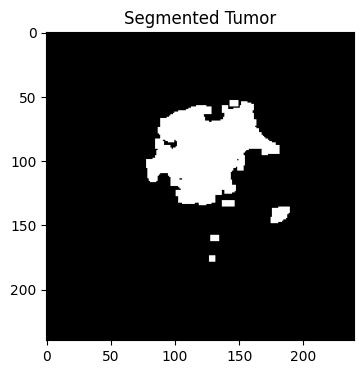

In [12]:
# Apply binary thresholding
_, thresh = cv2.threshold(equalized, 150, 255, cv2.THRESH_BINARY)

# Apply Morphological Operations to refine segmentation
kernel = np.ones((5,5), np.uint8)
segmented = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Show results
plt.figure(figsize=(6, 4))
plt.imshow(segmented, cmap="gray"), plt.title("Segmented Tumor")
plt.show()

## 4️⃣ Tumor Size Evaluation
Calculate tumor area using contour detection in OpenCV.

Measure pixel-to-mm conversion from DICOM metadata.

Compare tumor size with previous MRI scans using area difference.

💡 Code Example: Tumor Area Calculation

In [13]:
# Find tumor contours
contours, _ = cv2.findContours(segmented, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the largest contour (tumor region)
tumor_contour = max(contours, key=cv2.contourArea)
tumor_area = cv2.contourArea(tumor_contour)  # Area in pixels

# Convert pixels to mm² (assuming known pixel spacing from DICOM)
pixel_spacing = 0.5  # Example: 0.5 mm per pixel (change as per actual MRI data)
tumor_area_mm2 = tumor_area * (pixel_spacing ** 2)

print(f"Tumor Area: {tumor_area_mm2:.2f} mm²")

Tumor Area: 1175.50 mm²
